## Finite Differences

## Forward Euler

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# suppress scientific notation for now
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [90]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
rhomax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0
# Redfield ratio = 0.022 for q

A1_guess = 100.0
Rb1_guess = 2.2
Rd1_guess = 30.0

zmax = 20
delta_z = 0.001

In [91]:
def p(I,q):
    return mumax * (1 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

initial_conditions = np.array([A1_guess,
                              v*A1_guess/d,
                              Rb1_guess,
                              v*Rb1_guess/d,
                              Rd1_guess,
                              0.0,
                              I0])

np.set_printoptions(suppress=True)
print(initial_conditions)

[100.      2.5     2.2     0.055  30.      0.    300.   ]


In [105]:
def step_forward(y, z_start, delta_z):
    """Forward Euler next step where y is a vector of length 7 of initial guesses."""
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    A1_next = A1 - delta_z*A2
    A2_next = A2 + (delta_z/d)*(-v*A2 - p(I,q)*A1 + lbg*A1)
    Rb1_next = Rb1 - delta_z*Rb2
    Rb2_next = Rb2 + (delta_z/d)*(v*Rb2 - rho(q,Rd1)*A1 - lbg*Rb1)
    Rd1_next = Rd1 - delta_z*Rd2
    Rd2_next = Rd2 + (delta_z/d)*(rho(q,Rd1)*A1 - lbg*Rb1)
    I_next = I - delta_z*(k*A1 + kbg)*I
    
    return np.array([A1_next,
                     A2_next,
                     Rb1_next,
                     Rb2_next,
                     Rd1_next,
                     Rd2_next,
                     I_next])

In [106]:
first_step = step_forward(initial_conditions,0,delta_z)
stepdict = {'z0': initial_conditions, 'z1': first_step}
pd.DataFrame(stepdict, index=['A1','A2','Rb1','Rb2','Rd1','Rd2','I'])

,z0,z1
A1,100.0000,99.9975
A2,2.5000,2.4940
Rb1,2.2000,2.1999
Rb2,0.0550,0.0543
Rd1,30.0000,30.0000
Rd2,0.0000,0.0006
I,300.0000,299.8710


## Stepping over z

In [107]:
z_steps = np.arange(0.0,zmax,delta_z) 
steps = np.empty([len(initial_conditions),len(z_steps)])
steps[:,0] = initial_conditions

i=0
for z in z_steps[:-1]:
    i=i+1
    steps[:,i] = step_forward(steps[:,i-1], z, delta_z)

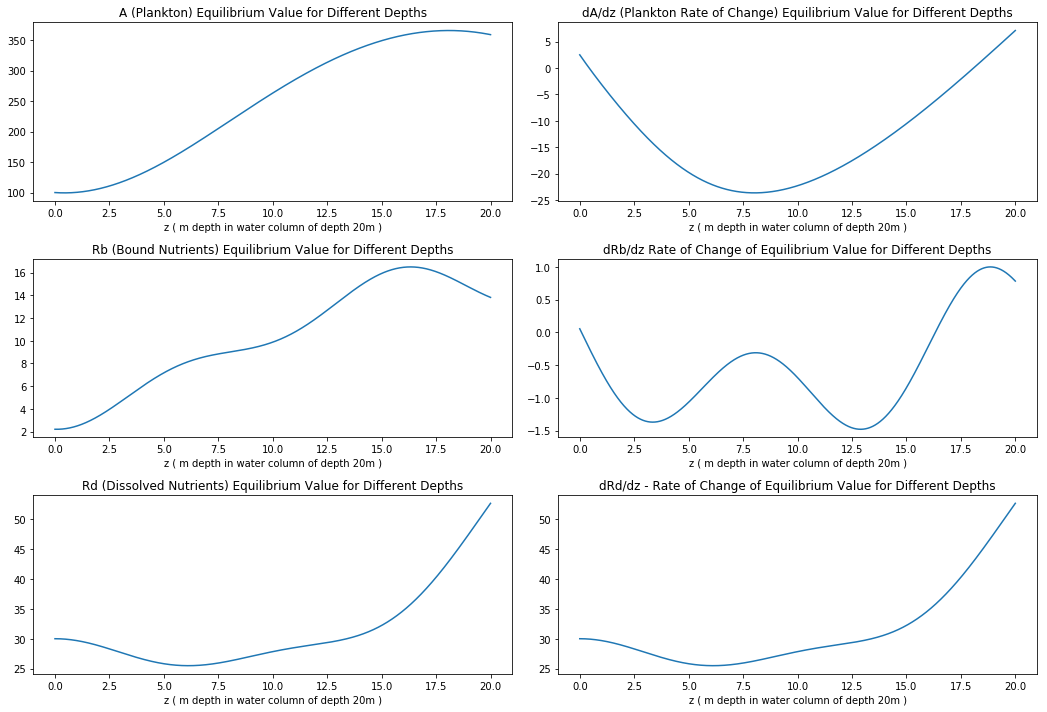

In [108]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(z_steps,steps[0,:])
axs[0,0].set_title('A (Plankton) Equilibrium Value for Different Depths')
axs[0,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[0,1].plot(z_steps,steps[1,:])
axs[0,1].set_title('dA/dz (Plankton Rate of Change) Equilibrium Value for Different Depths')
axs[0,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,0].plot(z_steps,steps[2,:])
axs[1,0].set_title('Rb (Bound Nutrients) Equilibrium Value for Different Depths')
axs[1,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,1].plot(z_steps,steps[3,:])
axs[1,1].set_title('dRb/dz Rate of Change of Equilibrium Value for Different Depths')
axs[1,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,0].plot(z_steps,steps[4,:])
axs[2,0].set_title('Rd (Dissolved Nutrients) Equilibrium Value for Different Depths')
axs[2,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,1].plot(z_steps,steps[4,:])
axs[2,1].set_title('dRd/dz - Rate of Change of Equilibrium Value for Different Depths')
axs[2,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

Text(0.5, 0, 'z ( m depth in water column of depth 20m )')

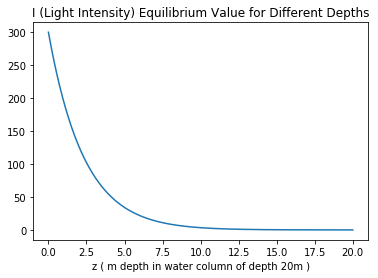

In [109]:
plt.plot(z_steps,steps[6,:])
plt.title('I (Light Intensity) Equilibrium Value for Different Depths')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))


In [110]:
steps_df = pd.DataFrame(steps, index = ['A1','A2','Rb2','Rb2','Rd1','Rd2','I'])
steps_df

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
A1,100.0000,99.9975,99.9950,99.9925,99.9900,99.9876,99.9851,99.9826,99.9802,99.9777,...,358.8921,358.8850,358.8779,358.8708,358.8638,358.8567,358.8496,358.8425,358.8354,358.8283
A2,2.5000,2.4940,2.4881,2.4822,2.4762,2.4703,2.4643,2.4584,2.4524,2.4465,...,7.0705,7.0743,7.0780,7.0818,7.0856,7.0893,7.0931,7.0968,7.1006,7.1044
Rb2,2.2000,2.1999,2.1999,2.1998,2.1998,2.1997,2.1997,2.1996,2.1996,2.1995,...,13.8218,13.8210,13.8203,13.8195,13.8187,13.8179,13.8171,13.8163,13.8156,13.8148
Rb2,0.0550,0.0543,0.0536,0.0529,0.0523,0.0516,0.0509,0.0502,0.0495,0.0488,...,0.7861,0.7858,0.7854,0.7851,0.7847,0.7844,0.7840,0.7837,0.7833,0.7829
Rd1,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,...,52.5536,52.5588,52.5639,52.5691,52.5742,52.5794,52.5845,52.5897,52.5948,52.6000
Rd2,0.0000,0.0006,0.0013,0.0019,0.0026,0.0032,0.0039,0.0045,0.0052,0.0058,...,-5.1531,-5.1530,-5.1529,-5.1528,-5.1527,-5.1526,-5.1525,-5.1525,-5.1524,-5.1523
I,300.0000,299.8710,299.7421,299.6132,299.4843,299.3556,299.2268,299.0982,298.9696,298.8410,...,0.0228,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227,0.0227


**Note**: changed equations to:

    A1' = -A2
    Rb1' = -Rb2
    Rd1' = -Rd2
    
and this seemed to resolve all the blowing up in forward Euler but I don't understand why it's ok to do. Something to do with 

    A1 goes down when A2 > 0

## Central Difference Method

In [77]:
def step_forward_cdm(y0,y1, z_start, delta_z):
    """Cental Differemnce/Forward Euler next step where y1 and y0 are vectors of length 4 of initial guesses."""
    A0 = y0[0]
    Rb0 = y0[1]
    Rd0 = y0[2]
    I0 = y0[3]
    
    A1 = y1[0] #
    Rb1 = y1[1] #
    Rd1 = y1[2]
    I1 = y1[3]
    
    q = Rb1/A1
    
    A_next = delta_z**2/(v*delta_z - d) * ( (p(I1,q) - lbg + v/delta_z - 2*d/delta_z**2)*A1 ) + d*A0/(v*delta_z-d)
    
    Rb_next = delta_z**2/(v*delta_z - d) * ( rho(q,Rd1)*A1 + (v/delta_z - lbg - 2*d/delta_z**2)*Rb1) + d*Rb0/(v*delta_z-d)
    
    Rd_next = delta_z**2/d * (rho(q,Rd1)*A1 - lbg*Rb1) + 2*Rd1 - Rd0
    
    I_next = -delta_z * (k*A1 + kbg )*I1 + I1 # taking negative of this function for now
    
    return np.array([A_next,
                     Rb_next,
                     Rd_next,
                     I_next])

In [78]:
initial_conditions0 = initial_conditions[[0,2,4,6]]
initial_conditions1 = first_step[[0,2,4,6]]

In [79]:
delta_z = 0.00001 # blowing up
z_steps = np.arange(0.0,zmax,delta_z) 

steps_cdm = np.empty([len(initial_conditions0),len(z_steps)])
steps_cdm[:,0] = initial_conditions0
steps_cdm[:,1] = initial_conditions1

In [80]:
i=1
for z in z_steps[:-2]:
    i=i+1
    #print(i)
    steps_cdm[:,i] = step_forward_cdm(steps_cdm[:,i-2],steps_cdm[:,i-1], z, delta_z)
    
# Note: overflow/invalid value encountered in double_scalar encountered at i = 1408

In [81]:
steps_cdm_df = pd.DataFrame(steps_cdm, index=['A','Rb','Rd','I'])
steps_cdm_df

,0,1,2,3,4,5,6,7,8,9,...,1999990,1999991,1999992,1999993,1999994,1999995,1999996,1999997,1999998,1999999
A,100.0000,100.0025,100.0050,100.0075,100.0100,100.0125,100.0150,100.0175,100.0200,100.0225,...,8576.3899,8576.3998,8576.4097,8576.4195,8576.4294,8576.4392,8576.4491,8576.4590,8576.4688,8576.4787
Rb,2.2000,2.2001,2.2001,2.2002,2.2002,2.2003,2.2003,2.2004,2.2004,2.2005,...,-8008298.4421,-8008359.6791,-8008420.9165,-8008482.1544,-8008543.3928,-8008604.6316,-8008665.8709,-8008727.1107,-8008788.3510,-8008849.5917
Rd,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,30.0000,...,7746623.3956,7746682.6303,7746741.8654,7746801.1011,7746860.3371,7746919.5737,7746978.8106,7747038.0481,7747097.2859,7747156.5243
I,300.0000,299.8710,299.8697,299.8684,299.8671,299.8658,299.8646,299.8633,299.8620,299.8607,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [83]:
#nullval = steps_cdm_df.columns[steps_cdm_df.isnull().any()][0]
#print("So the values become null at step {} and Rd is infinity at {}.".format(nullval,nullval-1))

In [85]:
#steps_cdm_df.iloc[:,nullval-1]

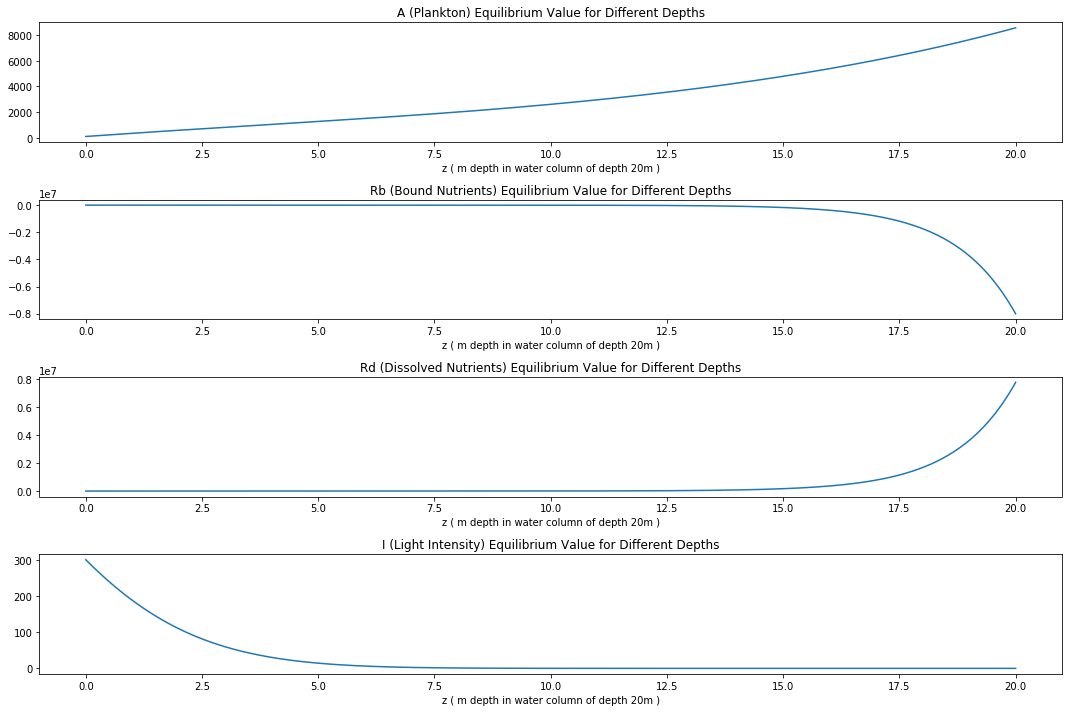

In [88]:
fig, axs = plt.subplots(4, figsize=(15,10))

axs[0].plot(z_steps,steps_cdm[0,:])
axs[0].set_title('A (Plankton) Equilibrium Value for Different Depths')
axs[0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1].plot(z_steps,steps_cdm[1,:])
axs[1].set_title('Rb (Bound Nutrients) Equilibrium Value for Different Depths')
axs[1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2].plot(z_steps,steps_cdm[2,:])
axs[2].set_title('Rd (Dissolved Nutrients) Equilibrium Value for Different Depths')
axs[2].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[3].plot(z_steps,steps_cdm[3,:])
axs[3].set_title('I (Light Intensity) Equilibrium Value for Different Depths')
axs[3].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

In [71]:
(rho(q,Rd1)*A1 - lbg*Rb1)

9.838449142728475